## Connect to Google Drive
Mount Google Drive so datasets and scripts stored there can be accessed in Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing Step
1. **Load data:** reads images and polygon labels.  
2. **Split sets:** splits train into **train (80%)** and **val (20%)**; official val used as **test**.  
3. **Convert labels:** polygons → bounding boxes, saved as COCO-style JSON formats:   
     - `train/instances_train.json`  
     - `val/instances_val.json`  
     - `test/instances_test.json`  
4. **Organize folders:** copies images/labels into `train/`, `val/`, `test/`.  


In [ ]:
%cd /content/drive/MyDrive/ML_projects/object-detection/src
!python preprocessing.py

## Visualize some training images with box labels

In [ ]:
import torch
from torchvision.datasets import CocoDetection
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

# -----------------------------
# Dataset (no resize)
# -----------------------------
class CocoOriginal(CocoDetection):
    def __init__(self, img_folder, ann_file):
        super().__init__(img_folder, ann_file)

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)  # PIL image + list of dicts
        return img, target

# -----------------------------
# Visualization Helper
# -----------------------------
def show_sample(dataset, idx=0):
    img, target = dataset[idx]   # PIL image, no resize
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)

    for obj in target:
        x, y, w, h = obj["bbox"]
        rect = patches.Rectangle(
            (x, y), w, h,
            linewidth=2, edgecolor="r", facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(x, y, str(obj["category_id"]),
                color="yellow", fontsize=8, backgroundcolor="black")

    ax.set_title(f"Sample {idx} – {len(target)} objects")
    plt.axis("off")
    plt.show()

# -----------------------------
# Paths
# -----------------------------
root_dir = "/content/drive/MyDrive/Datasets/DOTA_coco"
train_img_dir = os.path.join(root_dir, "train/images")
train_ann_file = os.path.join(root_dir, "train/instances_train.json")

# -----------------------------
# Load dataset + visualize
# -----------------------------
train_dataset = CocoOriginal(train_img_dir, train_ann_file)

# 🔍 Show some images with boxes

rand_indices = [0,5,20]
for idx in rand_indices:
    show_sample(train_dataset, idx=idx)


Output hidden; open in https://colab.research.google.com to view.

## Visualize resized images with scaled boxes overlaid  (used for training)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


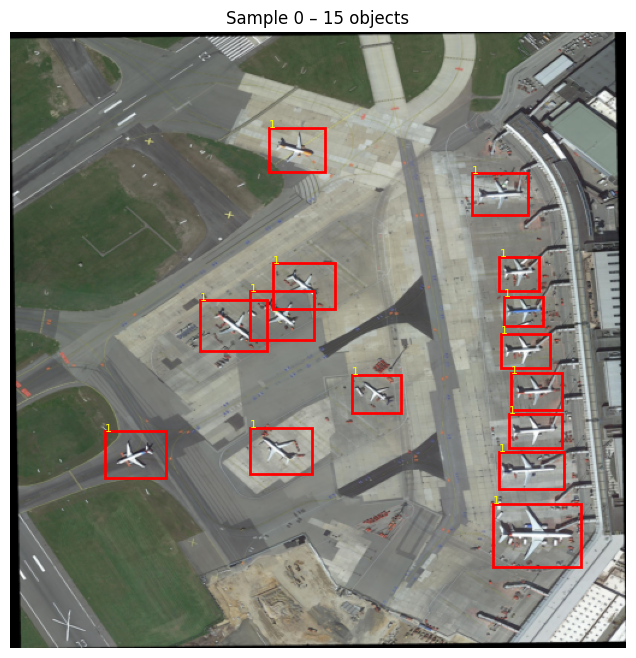

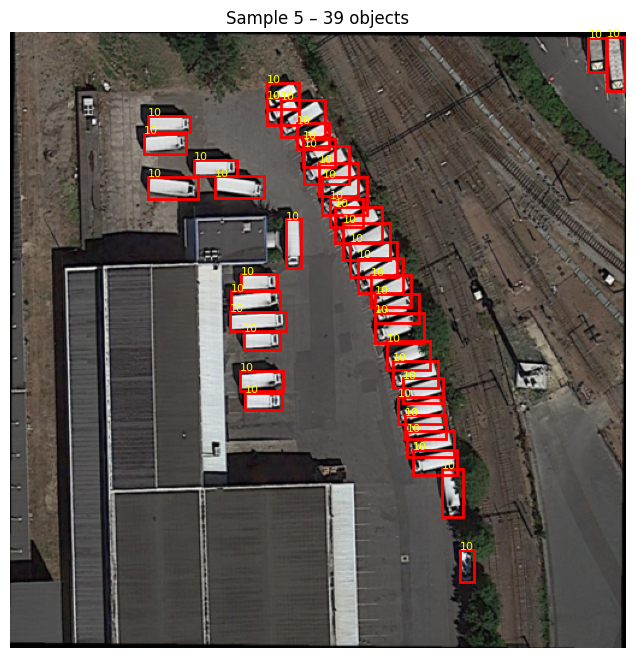

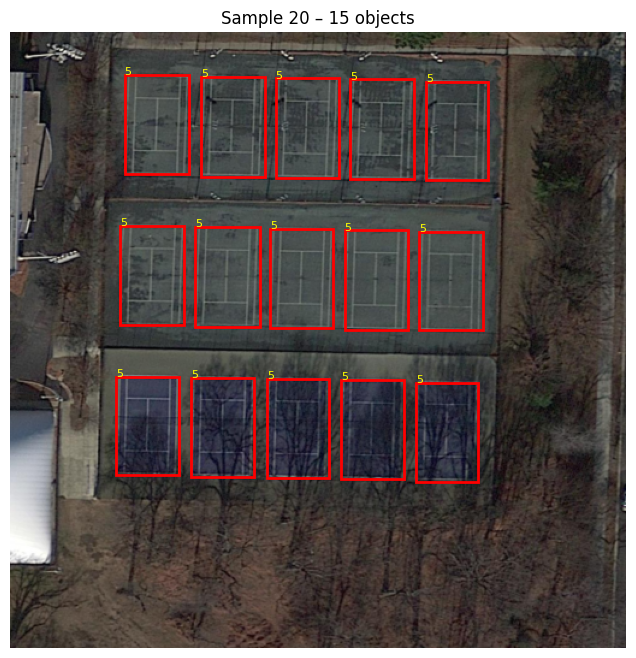

In [ ]:
import torch
import torchvision.transforms as T
from torchvision.datasets import CocoDetection
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

# -----------------------------
# Custom Resize with Boxes
# -----------------------------
class ResizeWithBoxes:
    def __init__(self, size=(512, 512)):
        self.size = size

    def __call__(self, image, target):
        w, h = image.size
        new_w, new_h = self.size

        # resize image
        image = image.resize((new_w, new_h), Image.BILINEAR)

        # scale boxes
        scale_x, scale_y = new_w / w, new_h / h
        for obj in target:
            x, y, bw, bh = obj["bbox"]
            x1 = x * scale_x
            y1 = y * scale_y
            x2 = (x + bw) * scale_x
            y2 = (y + bh) * scale_y
            obj["bbox"] = [x1, y1, x2 - x1, y2 - y1]  # back to [x,y,w,h]

        return image, target

# -----------------------------
# Dataset Wrapper
# -----------------------------
class CocoWithResize(CocoDetection):
    def __init__(self, img_folder, ann_file, resize_size=(512, 512)):
        super().__init__(img_folder, ann_file)
        self.resizer = ResizeWithBoxes(resize_size)
        self.to_tensor = T.ToTensor()

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        img, target = self.resizer(img, target)   # apply joint resize
        img = self.to_tensor(img)
        return img, target

# -----------------------------
# Visualization Helper
# -----------------------------
def show_sample(dataset, idx=0):
    img, target = dataset[idx]
    img_np = img.permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img_np)

    for obj in target:
        x, y, w, h = obj["bbox"]
        rect = patches.Rectangle(
            (x, y), w, h,
            linewidth=2, edgecolor="r", facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(x, y, str(obj["category_id"]),
                color="yellow", fontsize=8)

    ax.set_title(f"Sample {idx} – {len(target)} objects")
    plt.axis("off")
    plt.show()

# -----------------------------
# Paths
# -----------------------------
root_dir = "/content/drive/MyDrive/Datasets/DOTA_coco"
train_img_dir = os.path.join(root_dir, "train/images")
train_ann_file = os.path.join(root_dir, "train/instances_train.json")

# -----------------------------
# Load dataset + check samples
# -----------------------------
train_dataset = CocoWithResize(train_img_dir, train_ann_file, resize_size=(512, 512))

# 🔍 Show some resized images with scaled boxes

rand_indices = [0,5,20]
for idx in rand_indices:
    show_sample(train_dataset, idx=idx)


## Train Faster-RCNN Model

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms.functional as F
import os
from torchvision.datasets import CocoDetection


# -----------------------------
# Custom Resize Transform (image + bboxes)
# -----------------------------
class ResizeWithBoxes:
    def __init__(self, size=(512, 512)):
        self.size = size  # (height, width)

    def __call__(self, image, target):
        w, h = image.size
        new_h, new_w = self.size

        # Scale factors
        scale_x = new_w / w
        scale_y = new_h / h

        # Resize image
        image = F.resize(image, self.size)

        # Resize boxes if they exist
        if isinstance(target, list):
            for obj in target:
                if "bbox" in obj:
                    x, y, bw, bh = obj["bbox"]
                    obj["bbox"] = [
                        x * scale_x,
                        y * scale_y,
                        bw * scale_x,
                        bh * scale_y
                    ]
        return image, target


# -----------------------------
# Dataset Wrapper
# -----------------------------
class CocoWithResize(CocoDetection):
    def __init__(self, img_folder, ann_file, resize_size=(512, 512)):
        super().__init__(img_folder, ann_file)
        self.resizer = ResizeWithBoxes(resize_size)
        self.to_tensor = T.ToTensor()

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        img, target = self.resizer(img, target)   # apply joint resize
        img = self.to_tensor(img)
        return img, target


# -----------------------------
# 1. Dataset Setup
# -----------------------------
root_dir = "/content/drive/MyDrive/Datasets/DOTA_coco"

train_img_dir = os.path.join(root_dir, "train/images")
train_ann_file = os.path.join(root_dir, "train/instances_train.json")

val_img_dir = os.path.join(root_dir, "val/images")
val_ann_file = os.path.join(root_dir, "val/instances_val.json")

# Datasets
train_dataset = CocoWithResize(train_img_dir, train_ann_file, resize_size=(512, 512))
val_dataset   = CocoWithResize(val_img_dir, val_ann_file, resize_size=(512, 512))

# Build category id mapping (COCO → contiguous 1..N)
cat_ids = train_dataset.coco.getCatIds()
cat_id_to_contig = {cat_id: i+1 for i, cat_id in enumerate(cat_ids)}  # +1 to leave 0 as background
num_classes = len(cat_ids) + 1

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


# -----------------------------
# 2. Model Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

model.to(device)


# -----------------------------
# 3. Training Setup
# -----------------------------
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)  # 🔽 reduced LR
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


# -----------------------------
# Helper: Convert COCO annotations (with mapping + box sanity)
# -----------------------------
def convert_coco_targets(targets, device, img_size=(512, 512)):
    new_targets = []
    for t in targets:
        boxes, labels = [], []
        for obj in t:
            x1, y1, w, h = obj["bbox"]
            x2, y2 = x1 + w, y1 + h

            # Skip invalid boxes
            if w <= 1 or h <= 1:
                continue

            # Clamp to image size
            x1 = max(0, min(x1, img_size[1]-1))
            y1 = max(0, min(y1, img_size[0]-1))
            x2 = max(0, min(x2, img_size[1]-1))
            y2 = max(0, min(y2, img_size[0]-1))
            if x2 <= x1 or y2 <= y1:
                continue

            boxes.append([x1, y1, x2, y2])
            labels.append(cat_id_to_contig[obj["category_id"]])  # remap to contiguous

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)

        new_targets.append({
            "boxes": torch.tensor(boxes, dtype=torch.float32, device=device),
            "labels": torch.tensor(labels, dtype=torch.int64, device=device),
        })
    return new_targets


# -----------------------------
# 4. Training Loop
# -----------------------------
num_epochs = 100

for epoch in range(num_epochs):
    print(f"\n Starting Epoch [{epoch+1}/{num_epochs}]...")
    model.train()
    epoch_loss = 0.0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = convert_coco_targets(targets, device)

        if len(targets) == 0:  # skip if no valid target
            continue

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # gradient clipping
        optimizer.step()

        if torch.isnan(losses):
            print("⚠️ NaN detected, skipping batch")
            continue

        epoch_loss += losses.item()
        torch.cuda.empty_cache()

    lr_scheduler.step()

    # ---- Validation ----
    model.eval()
    val_outputs = []
    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)  # predictions only
            val_outputs.extend(outputs)

    print(f" Epoch [{epoch+1}/{num_epochs}] "
          f"- Train Loss: {epoch_loss:.4f} "
          f"- Val: ran {len(val_outputs)} images")

print("Training finished!")


# -----------------------------
# 5. Save Model
# -----------------------------
save_model_dir = "/content/drive/MyDrive/ML_projects/object-detection-fasterrcnn/runs"
os.makedirs(save_model_dir, exist_ok=True)

save_path = os.path.join(save_model_dir, "fasterrcnn_dota.pth")
torch.save(model.state_dict(), save_path)

print(f"Model saved at: {save_path}")


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!

🚀 Starting Epoch [1/30]...


/tmp/ipython-input-3178507392.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "boxes": torch.tensor(boxes, dtype=torch.float32, device=device),
/tmp/ipython-input-3178507392.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(labels, dtype=torch.int64, device=device),


✅ Epoch [1/30] - Train Loss: 658.5436 - Val: ran 92 images

🚀 Starting Epoch [2/30]...
✅ Epoch [2/30] - Train Loss: 550.3436 - Val: ran 92 images

🚀 Starting Epoch [3/30]...
✅ Epoch [3/30] - Train Loss: 345.9669 - Val: ran 92 images

🚀 Starting Epoch [4/30]...
✅ Epoch [4/30] - Train Loss: 208.0364 - Val: ran 92 images

🚀 Starting Epoch [5/30]...
✅ Epoch [5/30] - Train Loss: 138.4023 - Val: ran 92 images

🚀 Starting Epoch [6/30]...
✅ Epoch [6/30] - Train Loss: 87.1964 - Val: ran 92 images

🚀 Starting Epoch [7/30]...
✅ Epoch [7/30] - Train Loss: 60.6336 - Val: ran 92 images

🚀 Starting Epoch [8/30]...
✅ Epoch [8/30] - Train Loss: 46.1738 - Val: ran 92 images

🚀 Starting Epoch [9/30]...
✅ Epoch [9/30] - Train Loss: 38.2639 - Val: ran 92 images

🚀 Starting Epoch [10/30]...
✅ Epoch [10/30] - Train Loss: 27.6066 - Val: ran 92 images

🚀 Starting Epoch [11/30]...
✅ Epoch [11/30] - Train Loss: 22.3765 - Val: ran 92 images

🚀 Starting Epoch [12/30]...
✅ Epoch [12/30] - Train Loss: 16.9485 - Val:

## Run inference on test images and save results

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

# -----------------------------
# 1. Rebuild Test Dataset + Loader
# -----------------------------
test_img_dir = os.path.join(root_dir, "test/images")
test_ann_file = os.path.join(root_dir, "test/instances_test.json")

test_dataset = CocoWithResize(test_img_dir, test_ann_file, resize_size=(512, 512))
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

print(f"📂 Test set size: {len(test_dataset)} images")

# -----------------------------
# 2. Inference + Save Results
# -----------------------------
def run_inference_and_save(model, data_loader, device, save_dir, score_thresh=0.5):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    with torch.no_grad():
        for i, (images, targets) in enumerate(data_loader):
            images = [img.to(device) for img in images]
            outputs = model(images)

            img = images[0].permute(1, 2, 0).cpu().numpy()
            fig, ax = plt.subplots(1, figsize=(10, 10))
            ax.imshow(img)

            # Draw predictions
            boxes = outputs[0]["boxes"].cpu().numpy()
            scores = outputs[0]["scores"].cpu().numpy()
            labels = outputs[0]["labels"].cpu().numpy()

            for box, score, label in zip(boxes, scores, labels):
                if score < score_thresh:
                    continue
                x1, y1, x2, y2 = box
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                         linewidth=2, edgecolor="r", facecolor="none")
                ax.add_patch(rect)
                ax.text(x1, y1-5, f"{label}:{score:.2f}",
                        color="red", fontsize=8, backgroundcolor="white")

            save_path = os.path.join(save_dir, f"test_{i:04d}.png")
            plt.axis("off")
            plt.savefig(save_path, bbox_inches="tight", pad_inches=0.1)
            plt.close(fig)

            if i % 10 == 0:
                print(f"Saved {i+1}/{len(data_loader)} images")

    print(f"Inference complete. Results saved in {save_dir}")

# -----------------------------
# 3. Run on Test Set
# -----------------------------
run_inference_and_save(
    model,
    test_loader,
    device,
    save_dir="/content/drive/MyDrive/ML_projects/object-detection-fasterrcnn/runs/test_preds",
    score_thresh=0.5
)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
📂 Test set size: 12 images
Saved 1/12 images
Saved 11/12 images
✅ Inference complete. Results saved in /content/drive/MyDrive/ML_projects/object-detection-fasterrcnn/runs/test_preds
